In [1]:
from Import_IBKR_multi import IBKRConfig, connect_ibkr

cfg = IBKRConfig(
    host="127.0.0.1",
    port=7496,      # LIVE
    client_id=27,
    timeout=60,
)

ib = connect_ibkr(cfg)
print("Connected:", ib.isConnected())
print("Server version:", ib.client.serverVersion())


Connected: True
Server version: 176


Error 10168, reqId 4: Requested market data is not subscribed. Delayed market data is not enabled., contract: Stock(conId=13905935, symbol='8306', exchange='SMART', primaryExchange='TSEJ', currency='JPY', localSymbol='8306.T', tradingClass='8306')


In [2]:
from ib_insync import Stock

ib.reqMarketDataType(1)  # live data

c = Stock("8306", "SMART", "JPY", primaryExchange="TSEJ")
ib.qualifyContracts(c)

t = ib.reqMktData(c, "", True, False)  # snapshot
ib.sleep(3)

print("SNAP:", t.last, t.bid, t.ask, t.close)


SNAP: nan nan nan nan


In [3]:
ib.reqMarketDataType(3)  # DELAYED

from ib_insync import Stock
c = Stock("8306", "SMART", "JPY", primaryExchange="TSEJ")
ib.qualifyContracts(c)

t = ib.reqMktData(c, "", True, False)
ib.sleep(4)

print("DELAYED SNAP:", t.last, t.bid, t.ask, t.close)


DELAYED SNAP: 2494.1 2494.1 2494.5 2484.5


In [4]:
from ib_insync import Stock

c = Stock("8306", "SMART", "JPY", primaryExchange="TSEJ")
ib.qualifyContracts(c)

bars = ib.reqHistoricalData(
    c,
    endDateTime="",
    durationStr="10 D",
    barSizeSetting="15 mins",
    whatToShow="TRADES",
    useRTH=True,
    formatDate=1,
)

print("15m bars:", len(bars))
print("first/last:", bars[0].date, bars[-1].date)


15m bars: 828
first/last: 2025-12-12 17:00:00+09:00 2025-12-26 11:15:00+09:00


In [5]:
# ============================================================
# IMPORTS
# ============================================================

import importlib
import Import_IBKR_multi
importlib.reload(Import_IBKR_multi)

from Import_IBKR_multi import (
    IBKRConfig,
    connect_ibkr,
    unique_symbols_from_pairs,
    fetch_many_symbols,
    build_pair_frames,
)

# ============================================================
# PAIRS SETUP (JAPAN)
# ============================================================

RAW_PAIRS = [
    "8267.T-9020.T",
    "9301.T-9735.T",
    "8309.T-8316.T",
    "7751.T-7752.T",
    "1928.T-4452.T",
    "2002.T-2269.T",
    "6103.T-6113.T",
]

def parse_pairs(raw_pairs):
    pairs = []
    for s in raw_pairs:
        s = s.replace("–", "-").replace("—", "-").replace(" ", "")
        a, b = s.split("-")
        pairs.append((a, b))
    return pairs

PAIRS = parse_pairs(RAW_PAIRS)

# ============================================================
# DATE RANGE
# ============================================================
# Backtest range (safe). Change END="" later if you want "now".

START = "2023-11-01 00:00:00"
END   = "2024-12-01 00:00:00"

# ============================================================
# IBKR CONFIG (LIVE)
# ============================================================

cfg = IBKRConfig(
    host="127.0.0.1",
    port=7496,          # LIVE TWS
    client_id=34,
    sleep_seconds=1.2,
    timeout=60,
)

ib = connect_ibkr(cfg)

# IMPORTANT: use delayed market data (works during lunch / closed)
ib.reqMarketDataType(3)

print("Connected:", ib.isConnected())
print("Accounts:", ib.managedAccounts())

# ============================================================
# FETCH ALL SYMBOLS FROM IBKR
# ============================================================

SYMBOLS = unique_symbols_from_pairs(PAIRS)

symbol_frames = fetch_many_symbols(
    ib,
    SYMBOLS,
    START,
    END,
    cfg,
    verbose=True,
    use_cache=False,     # force API fetch
    save_cache=False
)

# ============================================================
# BUILD PAIR FRAMES (READY FOR STRATEGY)
# ============================================================

pair_frames = build_pair_frames(
    symbol_frames,
    PAIRS,
    how="inner"
)

# ============================================================
# QUICK SANITY CHECK
# ============================================================

prices_jp = pair_frames[("8267.T", "9020.T")]
prices_jp.head()


RuntimeError: This event loop is already running

API connection failed: ConnectionRefusedError(61, "Connect call failed ('127.0.0.1', 7496)")
Make sure API port on TWS/IBG is open


In [18]:
# ============================================================
# SAVE EACH TICKER TO ITS OWN CSV (STANDARD FORMAT: date,<TICKER>)
# Overwrites files if they already exist
# ============================================================

from pathlib import Path
import pandas as pd

OUT_DIR = Path("data/tickers")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def standardize_one_ticker(sym: str, obj) -> pd.DataFrame:
    """
    Returns a DataFrame with:
      - DatetimeIndex named 'date'
      - exactly ONE column named sym
      - sorted index
      - no NaNs
    Accepts:
      - pd.DataFrame (already has sym column or any single column)
      - pd.Series
      - dict wrapper like {"bars": df}
    """
    # If your fetch function returns dict wrappers (metadata + df)
    if isinstance(obj, dict):
        for key in ["df", "bars", "data", "prices", "frame"]:
            if key in obj and isinstance(obj[key], (pd.DataFrame, pd.Series)):
                obj = obj[key]
                break

    # Convert to DataFrame with one column named sym
    if isinstance(obj, pd.Series):
        df = obj.to_frame(name=sym)

    elif isinstance(obj, pd.DataFrame):
        df = obj.copy()

        if sym in df.columns:
            df = df[[sym]]
        else:
            # take first column and rename to sym
            df = df.iloc[:, [0]].rename(columns={df.columns[0]: sym})

    else:
        raise TypeError(f"{sym}: unsupported type {type(obj)}")

    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        # if it came with a date column instead of index
        if "date" in df.columns:
            df["date"] = pd.to_datetime(df["date"])
            df = df.set_index("date")
        else:
            raise ValueError(f"{sym}: expected DatetimeIndex or a 'date' column.")

    # Sort + set index name to match your desired CSV
    df = df.sort_index()
    df.index.name = "date"

    # Keep timezone in index (matches your sample). If you prefer UTC-naive CSV, use:
    # if df.index.tz is not None:
    #     df.index = df.index.tz_convert("UTC").tz_localize(None)

    # Force numeric and drop missing rows
    df[sym] = pd.to_numeric(df[sym], errors="coerce")
    df = df.dropna()

    # Guarantee exactly one column and correct name
    df = df[[sym]]

    return df

saved = 0
for sym, obj in symbol_frames.items():
    df = standardize_one_ticker(sym, obj)
    out_path = OUT_DIR / f"{sym}.csv"
    df.to_csv(out_path)  # overwrites by default
    saved += 1

print(f"Saved {saved} standardized ticker CSVs to: {OUT_DIR.resolve()}")


Saved 14 standardized ticker CSVs to: /Users/damiruranasinghe/Desktop/PairsTrading/data/tickers


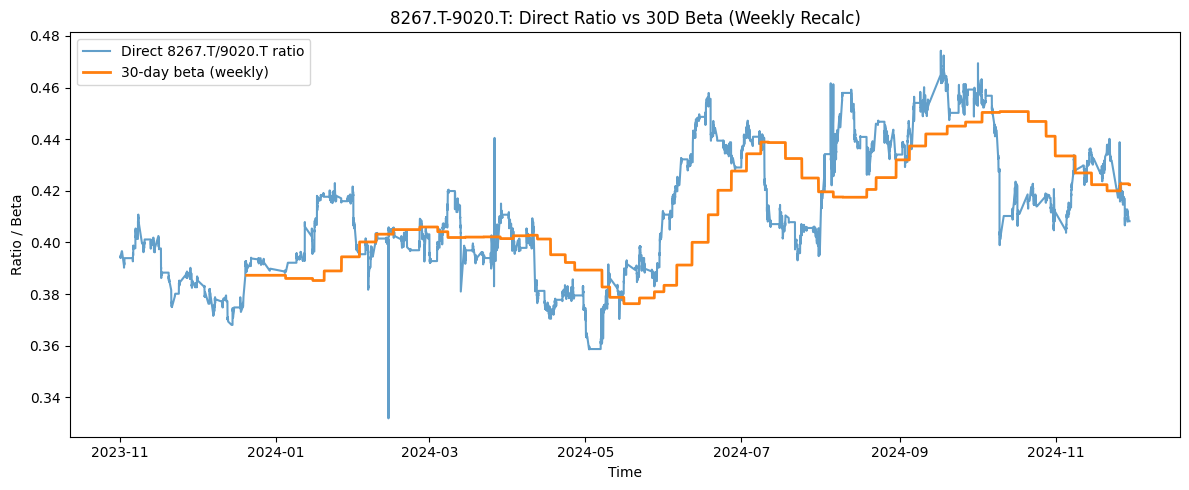

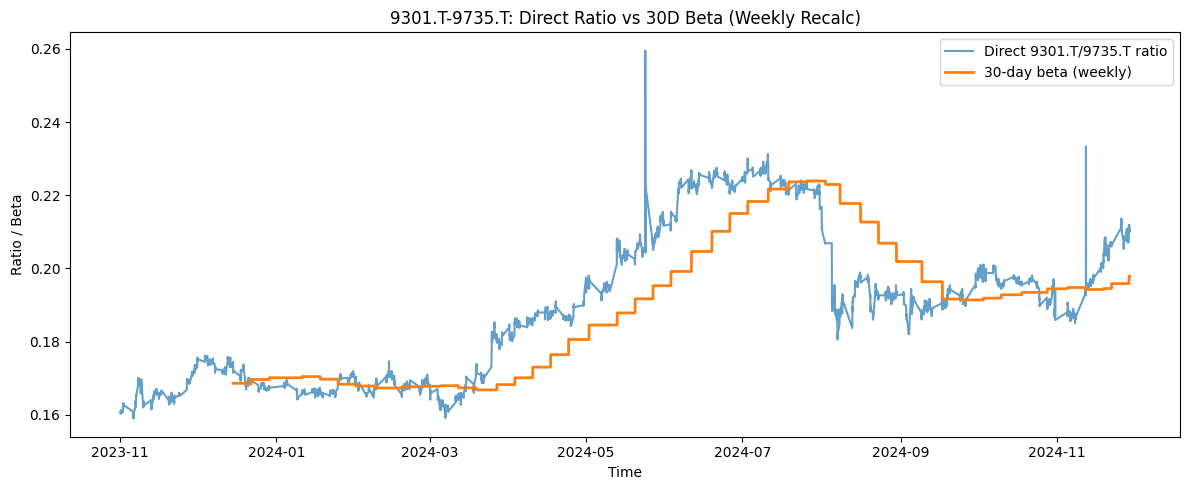

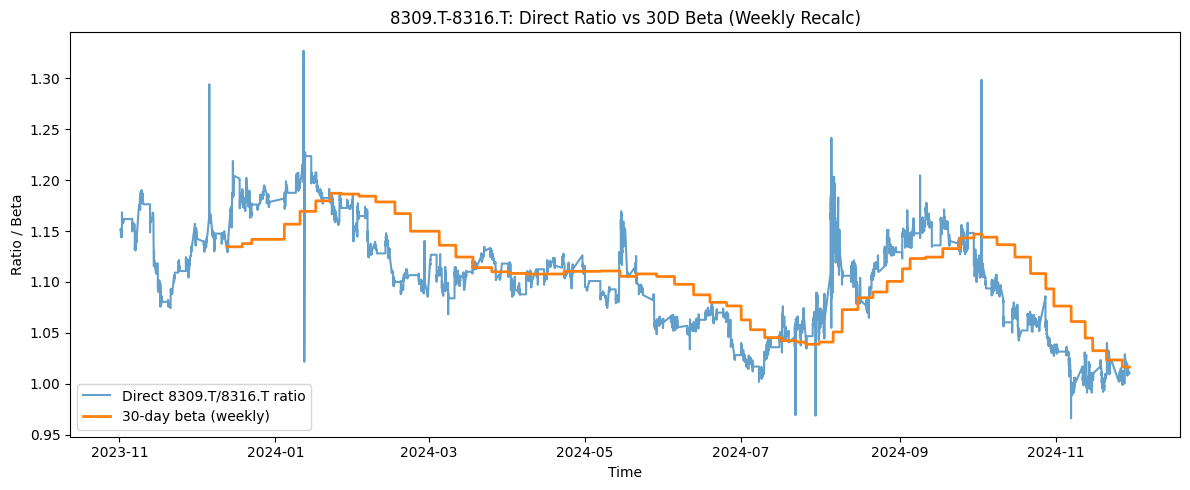

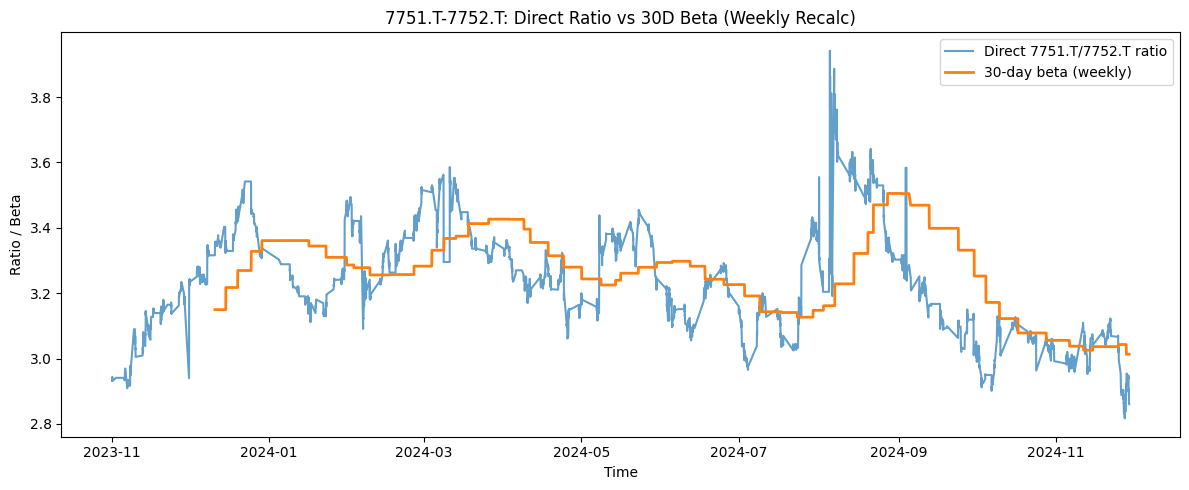

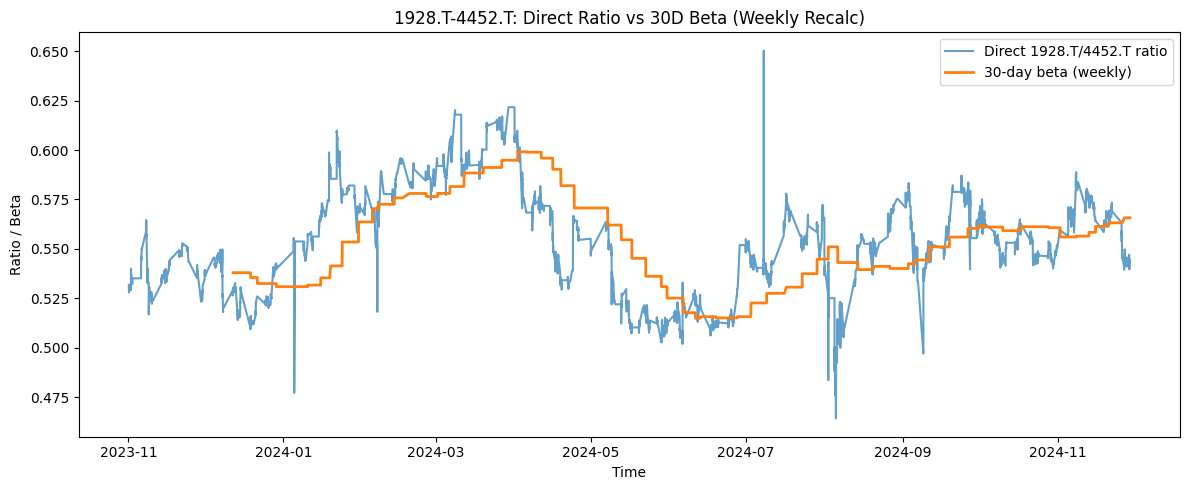

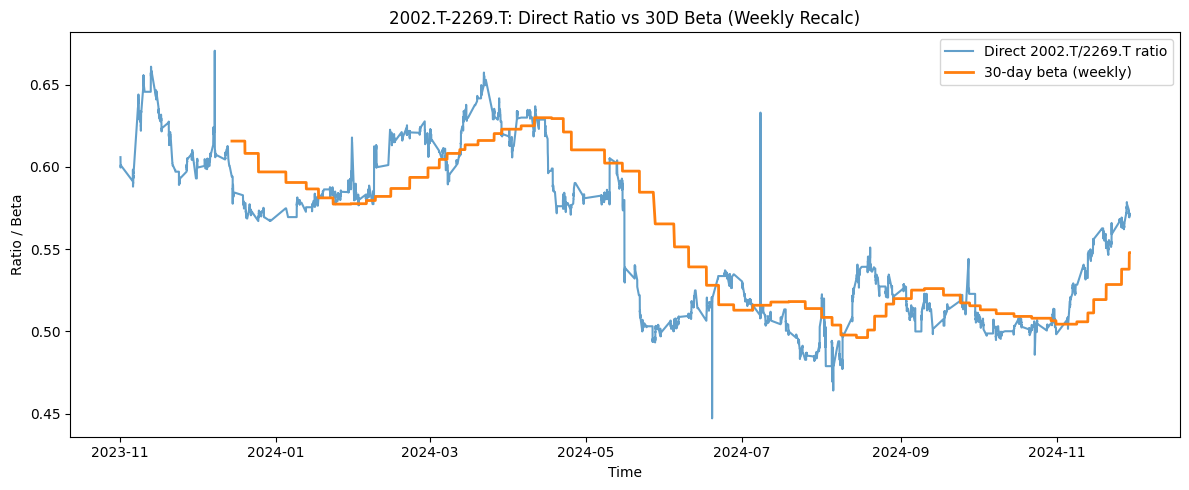

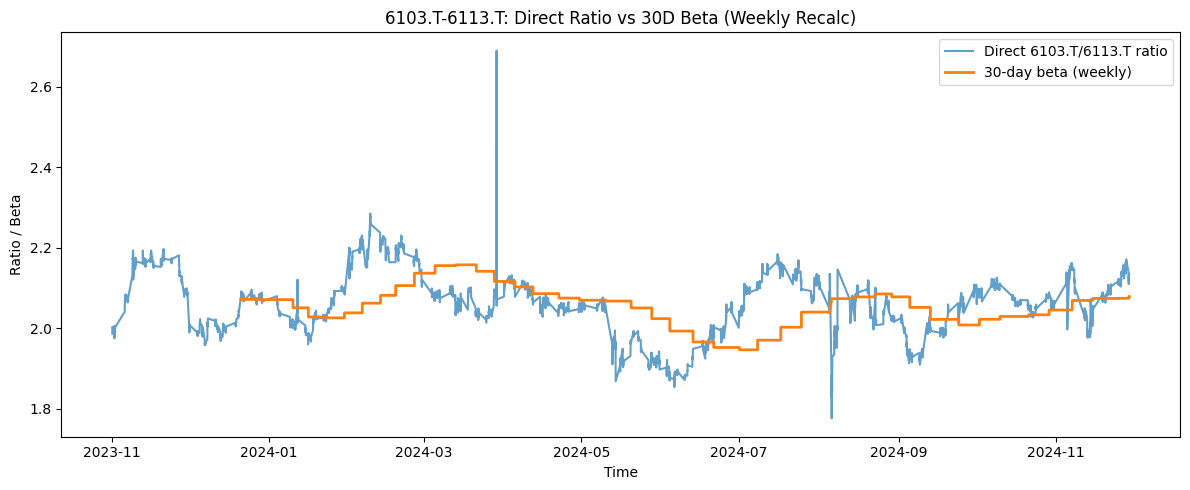

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_ratio_and_beta_weekly(
    prices, sym1, sym2,
    lookback_days=30,
    rebalance_days=5,
    min_days_required=35
):
    # --- Ensure clean datetime index (no NaT) ---
    prices = prices.copy()

    # If index isn't a proper DatetimeIndex, convert it
    if not isinstance(prices.index, pd.DatetimeIndex):
        prices.index = pd.to_datetime(prices.index, errors="coerce")

    # Drop rows where index failed to parse (NaT)
    prices = prices[~prices.index.isna()].sort_index()

    # Also ensure the two columns are numeric
    s1 = pd.to_numeric(prices[sym1], errors="coerce")
    s2 = pd.to_numeric(prices[sym2], errors="coerce")

    # 15-min ratio
    ratio_15m = (s1 / s2).dropna()
    ratio_15m = ratio_15m[~ratio_15m.index.isna()]  # extra safety

    if ratio_15m.empty:
        print(f"[SKIP] {sym1}-{sym2}: ratio series empty.")
        return

    # infer bars/day from the data
    bars_per_day = int(ratio_15m.groupby(ratio_15m.index.date).size().median())
    if bars_per_day <= 0:
        print(f"[SKIP] {sym1}-{sym2}: couldn't infer bars/day.")
        return

    # require enough history for 30D rolling to be meaningful
    approx_days = len(ratio_15m) / bars_per_day
    if approx_days < min_days_required:
        print(f"[SKIP] {sym1}-{sym2}: only ~{approx_days:.1f} trading days of data.")
        return

    lookback = lookback_days * bars_per_day
    rebalance = rebalance_days * bars_per_day

    beta_hat = ratio_15m.rolling(lookback).mean()

    mask = np.zeros(len(beta_hat), dtype=bool)
    mask[::rebalance] = True
    beta_30_weekly = beta_hat.where(mask).ffill().shift(1)

    # --- Matplotlib sometimes chokes on tz-aware indexes; convert to naive UTC ---
    x_ratio = ratio_15m.index.tz_convert("UTC").tz_localize(None) if ratio_15m.index.tz is not None else ratio_15m.index
    x_beta  = beta_30_weekly.index.tz_convert("UTC").tz_localize(None) if beta_30_weekly.index.tz is not None else beta_30_weekly.index

    plt.figure(figsize=(12, 5))
    plt.plot(x_ratio, ratio_15m.values, label=f"Direct {sym1}/{sym2} ratio", alpha=0.7)
    plt.plot(x_beta, beta_30_weekly.values, label=f"{lookback_days}-day beta (weekly)", linewidth=2)

    plt.title(f"{sym1}-{sym2}: Direct Ratio vs {lookback_days}D Beta (Weekly Recalc)")
    plt.xlabel("Time")
    plt.ylabel("Ratio / Beta")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ---- PLOTS FOR ALL PAIRS ----
for (sym1, sym2), df in pair_frames.items():
    plot_ratio_and_beta_weekly(df, sym1, sym2, lookback_days=30, rebalance_days=5)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_zscore_and_histogram(
    prices,
    sym1,
    sym2,
    lookback_days=30,
    rebalance_days=5,
    min_days_required=35,
):
    # ---------------- Ratio / Spread ----------------
    spread_15m = (prices[sym1] / prices[sym2]).dropna()
    if spread_15m.empty:
        print(f"[SKIP] {sym1}-{sym2}: empty spread.")
        return

    # infer bars/day
    bars_per_day = int(spread_15m.groupby(spread_15m.index.date).size().median())
    if bars_per_day <= 0:
        print(f"[SKIP] {sym1}-{sym2}: couldn't infer bars/day.")
        return

    approx_days = len(spread_15m) / bars_per_day
    if approx_days < min_days_required:
        print(f"[SKIP] {sym1}-{sym2}: only ~{approx_days:.1f} trading days.")
        return

    lookback = lookback_days * bars_per_day
    rebalance = rebalance_days * bars_per_day

    # ---------------- Rolling mean & std ----------------
    spread_mean_hat = spread_15m.rolling(lookback).mean()
    spread_std_hat  = spread_15m.rolling(lookback).std()

    # weekly sampling, hold, shift to avoid lookahead
    mask = np.zeros(len(spread_15m), dtype=bool)
    mask[::rebalance] = True

    spread_mean_30_weekly = spread_mean_hat.where(mask).ffill().shift(1)
    spread_std_30_weekly  = spread_std_hat.where(mask).ffill().shift(1)

    # ---------------- Z-score ----------------
    zscore = (spread_15m - spread_mean_30_weekly) / spread_std_30_weekly
    z = zscore.dropna()

    if z.empty:
        print(f"[SKIP] {sym1}-{sym2}: z-score empty.")
        return

    # ---------------- Z-score time series ----------------
    plt.figure(figsize=(12, 5))
    plt.plot(zscore, linewidth=2)
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.title(f"{sym1}-{sym2}: Z-score (30D, weekly recalculation)")
    plt.xlabel("Time")
    plt.ylabel("Z-score")
    plt.tight_layout()
    plt.show()

    # ---------------- Z-score histogram ----------------
    plt.figure(figsize=(8, 5))
    for v in [-3, -2, -1, 0, 1, 2, 3]:
        plt.axvline(v, linestyle="--", linewidth=1)

    plt.hist(z, bins=50, density=True, alpha=0.7)
    plt.title(f"{sym1}-{sym2}: Z-score distribution")
    plt.xlabel("Z-score")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

for (sym1, sym2), df in pair_frames.items():
    plot_zscore_and_histogram(
        df,
        sym1,
        sym2,
        lookback_days=30,
        rebalance_days=5,
    )


NameError: name 'pair_frames' is not defined

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 0) YOUR PAIRS
# ============================================================

RAW_PAIRS = [
    "8267.T-9020.T",
    "9301.T-9735.T",
    "8309.T-8316.T",
    "7751.T-7752.T",
    "1928.T-4452.T",
    "2002.T-2269.T",
    "6103.T-6113.T",
]

# thresholds per pair (same for all here, but you can customize)
Z_ENTER_DEFAULT = 3.5
Z_EXIT_DEFAULT  = 1.0

THRESHOLDS = {}
for p in RAW_PAIRS:
    a, b = p.split("-")
    THRESHOLDS[(a, b)] = {"Z_enter": Z_ENTER_DEFAULT, "Z_exit": Z_EXIT_DEFAULT}

# ============================================================
# 1) PARAMETERS
# ============================================================

LOOKBACK_DAYS   = 30
REBALANCE_DAYS  = 5
MAX_DRIFT_PCT   = 7

# ============================================================
# 2) HELPERS
# ============================================================

def infer_bars_per_day(series: pd.Series) -> int:
    return int(series.groupby(series.index.date).size().median())

def weekly_hold(series: pd.Series, step: int) -> pd.Series:
    mask = np.zeros(len(series), dtype=bool)
    mask[::step] = True
    return series.where(mask).ffill().shift(1)

def compute_weekly_beta_and_zscore(ratio_15m: pd.Series, bars_per_day: int):
    lookback  = LOOKBACK_DAYS * bars_per_day
    rebalance = REBALANCE_DAYS * bars_per_day

    mean_hat = ratio_15m.rolling(lookback).mean()
    std_hat  = ratio_15m.rolling(lookback).std()

    mean_weekly = weekly_hold(mean_hat, rebalance)
    std_weekly  = weekly_hold(std_hat,  rebalance).replace(0, np.nan)

    beta_weekly = mean_weekly
    zscore = (ratio_15m - mean_weekly) / std_weekly
    return beta_weekly, zscore

def build_pair_frames_from_prices(prices: pd.DataFrame, thresholds: dict) -> dict:
    """
    prices: DataFrame with DatetimeIndex, columns include all tickers.
    returns dict {(sym1, sym2): df[[sym1, sym2]]}
    """
    pair_frames = {}
    for (sym1, sym2) in thresholds.keys():
        if sym1 not in prices.columns or sym2 not in prices.columns:
            print(f"Skipping {sym1}-{sym2}: missing columns in prices")
            continue
        df = prices[[sym1, sym2]].dropna()
        if df.empty:
            print(f"Skipping {sym1}-{sym2}: empty after dropna")
            continue
        pair_frames[(sym1, sym2)] = df
    return pair_frames

def build_global_time_index(pair_frames: dict) -> pd.DatetimeIndex:
    idx = None
    for _, df in pair_frames.items():
        di = pd.DatetimeIndex(df.index)
        idx = di if idx is None else idx.union(di)
    return idx.sort_values()

def open_trades_timeseries(all_trades_df: pd.DataFrame, time_index: pd.DatetimeIndex) -> pd.Series:
    """
    Open trades count at each timestamp.
    Convention: trade is open from entry_time inclusive to exit_time exclusive.
    Uses asof alignment to avoid missing timestamps due to tz/rounding.
    """
    if all_trades_df.empty:
        return pd.Series(0, index=time_index, dtype=int)

    time_index = time_index.sort_values()

    entry_t = pd.to_datetime(all_trades_df["entry_time"])
    exit_t  = pd.to_datetime(all_trades_df["exit_time"])

    events = pd.Series(0, index=time_index, dtype=int)

    for t in entry_t:
        pos = time_index.searchsorted(t, side="right") - 1
        if pos >= 0:
            events.iloc[pos] += 1

    for t in exit_t:
        pos = time_index.searchsorted(t, side="right") - 1
        if pos >= 0:
            events.iloc[pos] -= 1

    return events.cumsum()

# ============================================================
# 3) BACKTEST ONE PAIR (trade log format like your example)
# ============================================================

def backtest_pair(prices_2col: pd.DataFrame, sym1: str, sym2: str, z_enter: float, z_exit: float):
    s1 = prices_2col[sym1]
    s2 = prices_2col[sym2]

    ratio = (s1 / s2).dropna()
    if ratio.empty:
        return pd.DataFrame(), {
            "pair": f"{sym1}-{sym2}",
            "sym1": sym1,
            "sym2": sym2,
            "reason": "empty ratio",
            "len_z": 0,
            "max_abs_z": np.nan,
            "entries_hit": 0,
            "exits_hit": 0,
            "skipped_trades": 0,
            "trades_generated": 0,
            "bars_per_day": np.nan,
            "total_pnl_dollars": 0.0,
            "avg_pnl_dollars": 0.0,
            "avg_pnl_pct": 0.0,
        }

    bars_per_day = infer_bars_per_day(ratio)
    beta_weekly, zscore = compute_weekly_beta_and_zscore(ratio, bars_per_day)
    z = zscore.dropna()

    trades = []
    skipped_trades = 0
    in_trade = False
    entry = None

    entries_hit = int((z.abs() >= z_enter).sum())
    exits_hit   = int((z.abs() <= z_exit).sum())
    max_abs_z   = float(z.abs().max()) if len(z) else np.nan

    for i, (t, zi) in enumerate(z.items()):

        # ENTRY
        if (not in_trade) and (abs(zi) >= z_enter):
            beta_entry = float(beta_weekly.loc[t])

            entry_price_stock1 = float(s1.loc[t])
            entry_price_stock2 = float(s2.loc[t])

            direct_beta = entry_price_stock1 / entry_price_stock2 if entry_price_stock2 != 0 else np.nan
            drift_pct = abs(100.0 * (direct_beta - beta_entry) / beta_entry) if beta_entry != 0 else np.inf

            if drift_pct >= MAX_DRIFT_PCT:
                skipped_trades += 1
                continue

            entry = {
                "pair": f"{sym1}-{sym2}",
                "direction": "SHORT_SPREAD" if zi > 0 else "LONG_SPREAD",
                "entry_time": t,
                "entry_price_stock1": entry_price_stock1,
                "entry_price_stock2": entry_price_stock2,
                "beta_entry": beta_entry,
                "entry_drift_pct": float(drift_pct),
                "entry_idx": i,
            }
            in_trade = True

        # EXIT
        elif in_trade and (abs(zi) <= z_exit):
            exit_time = t
            exit_price_stock1 = float(s1.loc[t])
            exit_price_stock2 = float(s2.loc[t])

            beta_exit = float(beta_weekly.loc[t])
            beta_change_pct = 100.0 * (beta_exit - entry["beta_entry"]) / entry["beta_entry"] if entry["beta_entry"] != 0 else np.nan

            d1 = exit_price_stock1 - entry["entry_price_stock1"]
            d2 = exit_price_stock2 - entry["entry_price_stock2"]

            # Dollar PnL (1 share stock1 vs beta shares stock2)
            if entry["direction"] == "LONG_SPREAD":
                pnl_dollars = d1 - entry["beta_entry"] * d2
            else:
                pnl_dollars = -d1 + entry["beta_entry"] * d2

            # FIXED: % return on gross notional at entry (both legs)
            gross_notional = abs(entry["entry_price_stock1"]) + abs(entry["beta_entry"] * entry["entry_price_stock2"])
            pnl_pct = pnl_dollars / gross_notional if gross_notional != 0 else np.nan

            holding_bars = int(i - entry["entry_idx"])

            trades.append({
                "pair": entry["pair"],
                "direction": entry["direction"],
                "entry_time": entry["entry_time"],
                "exit_time": exit_time,
                "entry_price_stock1": entry["entry_price_stock1"],
                "exit_price_stock1": exit_price_stock1,
                "entry_price_stock2": entry["entry_price_stock2"],
                "exit_price_stock2": exit_price_stock2,
                "beta_entry": entry["beta_entry"],
                "beta_exit": beta_exit,
                "beta_change_pct": float(beta_change_pct),
                "entry_drift_pct": entry["entry_drift_pct"],
                "holding_bars": holding_bars,
                "holding_days": float(holding_bars / bars_per_day),
                "pnl_dollars": float(pnl_dollars),
                "pnl_pct": float(pnl_pct),
            })

            in_trade = False
            entry = None

    trades_df = pd.DataFrame(trades)

    stats = {
        "pair": f"{sym1}-{sym2}",
        "sym1": sym1,
        "sym2": sym2,
        "len_z": int(len(z)),
        "max_abs_z": float(max_abs_z) if pd.notna(max_abs_z) else np.nan,
        "entries_hit": int(entries_hit),
        "exits_hit": int(exits_hit),
        "skipped_trades": int(skipped_trades),
        "trades_generated": int(len(trades_df)),
        "bars_per_day": int(bars_per_day),
        "total_pnl_dollars": float(trades_df["pnl_dollars"].sum()) if not trades_df.empty else 0.0,
        "avg_pnl_dollars": float(trades_df["pnl_dollars"].mean()) if not trades_df.empty else 0.0,
        "avg_pnl_pct": float(trades_df["pnl_pct"].mean()) if not trades_df.empty else 0.0,
        "reason": "ok",
    }

    # convert datetimes to strings so Jupyter/terminal always prints them
    if not trades_df.empty:
        for c in ["entry_time", "exit_time"]:
            trades_df[c] = trades_df[c].astype(str)

    return trades_df, stats

# ============================================================
# 4) RUN ALL PAIRS
# ============================================================
# REQUIREMENT: you must have a DataFrame named `prices` already loaded:
# - DatetimeIndex
# - columns include all tickers in RAW_PAIRS

pair_frames = build_pair_frames_from_prices(prices, THRESHOLDS)

trade_logs = {}
pair_stats = []
all_trades = []

for (sym1, sym2), df in pair_frames.items():
    th = THRESHOLDS[(sym1, sym2)]
    trades_df, stats = backtest_pair(df, sym1, sym2, th["Z_enter"], th["Z_exit"])

    trade_logs[(sym1, sym2)] = trades_df
    pair_stats.append(stats)
    if not trades_df.empty:
        all_trades.append(trades_df)

pair_stats_df = pd.DataFrame(pair_stats)
all_trades_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame()

# ============================================================
# 5) OUTPUTS (like your print style)
# ============================================================

print("PAIRS PROCESSED:", len(pair_stats_df))

if not pair_stats_df.empty:
    for _, row in pair_stats_df.iterrows():
        print("\n==============================")
        print("PAIR:", row["pair"])
        print("len(z):", int(row["len_z"]))
        print("max |z|:", float(row["max_abs_z"]) if pd.notna(row["max_abs_z"]) else np.nan)
        print(f"entries hit (|z|>={THRESHOLDS[(row['sym1'], row['sym2'])]['Z_enter']}):", int(row["entries_hit"]))
        print(f"exits hit (|z|<={THRESHOLDS[(row['sym1'], row['sym2'])]['Z_exit']}):", int(row["exits_hit"]))
        print(f"entries skipped (drift >= {MAX_DRIFT_PCT}%):", int(row["skipped_trades"]))
        print("trades generated:", int(row["trades_generated"]))
        print("Total P&L $:", float(row["total_pnl_dollars"]))
        print("Avg P&L $ per trade:", float(row["avg_pnl_dollars"]))
        print("Avg P&L % per trade (gross notional):", float(row["avg_pnl_pct"]))

# ---- PRINT ALL TRADES ----
if all_trades_df.empty:
    print("\nNO COMPLETED TRADES (ALL PAIRS)")
else:
    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 220)
    pd.set_option("display.max_colwidth", 60)

    tmp = all_trades_df.copy()
    tmp["_entry_time_dt"] = pd.to_datetime(tmp["entry_time"])
    tmp = tmp.sort_values("_entry_time_dt").drop(columns=["_entry_time_dt"])

    print("\n===== ALL TRADES (ALL PAIRS) =====")
    print(tmp.to_string(index=False))

    print("\nTOTAL P&L $ (ALL TRADES):", float(all_trades_df["pnl_dollars"].sum()))
    print("AVG P&L $ PER TRADE:", float(all_trades_df["pnl_dollars"].mean()))
    print("AVG P&L % PER TRADE (gross notional):", float(all_trades_df["pnl_pct"].mean()))

# ---- Pair summary table ----
if not pair_stats_df.empty:
    pair_stats_df_sorted = pair_stats_df.sort_values("total_pnl_dollars", ascending=False)
    display_cols = ["pair", "trades_generated", "skipped_trades", "total_pnl_dollars", "avg_pnl_dollars", "avg_pnl_pct"]
    print("\n===== PAIR SUMMARY =====")
    print(pair_stats_df_sorted[display_cols].to_string(index=False))

# ---- Open trades over time + plot ----
global_index = build_global_time_index(pair_frames)
open_trades_ts = open_trades_timeseries(all_trades_df, global_index)

print("\nMax simultaneous open trades:", int(open_trades_ts.max()) if len(open_trades_ts) else 0)

plt.figure(figsize=(12, 4))
plt.plot(open_trades_ts.index, open_trades_ts.values)
plt.title("Number of Open Trades Over Time")
plt.xlabel("Time")
plt.ylabel("Open Trades")
plt.grid(True, alpha=0.3)
plt.show()


NameError: name 'prices' is not defined